In [ ]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

---
## Loading/Saving Data
 - `census_zip`: census demographic data by zipcode
 - `age_census`: census age data by zipcode
 - `area_facility`: population and area by facility ID
    - separated by **noise limited**, **terrain limited**, and **interference free**
    - only `interference free` used
 - `win_bids`:  winning bids data on Auction 1001
 - `dma_county`: dma to county mapping (11 split counties)
 - `demographic_county`: census demographic data by county
 - `education_county`: census education data by county
 - `dma_zip`: dma to zipcode mapping
 

In [ ]:
census_zip = pd.read_csv("data/census_zip.csv", engine="pyarrow")
age_census = pd.read_csv('data/census/age_census.csv', header=1, engine='pyarrow')
area_facility = pd.read_excel("data/areaFacility.xlsx", header=5)
win_bids = pd.read_csv("data/winning_bids.csv")
dma_county = pd.read_csv("data/dma_to_county.csv", engine="pyarrow")
demographic_county = pd.read_csv("data/census/demographic_county.csv", header=1, engine="c")
education_county = pd.read_csv("data/census/education_county.csv", header=1, engine="pyarrow")
dma_zip = pd.read_csv("data/dma_to_zipcode.csv", engine='pyarrow')

---
#### Exploratory Analysis on `age_census`

In [ ]:
age_census.head()

#### Renaming columns of `age_census` for readability

In [ ]:
def column_rename(df):
    new_columns = []

    new_columns.append(df.columns[0])
    new_columns.append(df.columns[1])

    for c in range(2, len(df.columns)):
        new_columns.append("_".join(df.columns[c].split("!!")))

    df.columns = new_columns

    return df

age_census = column_rename(age_census)

#### Create `zipcode` column from ZCTA data

In [ ]:
age_census['zipcode'] = age_census["Geography"].apply(lambda x: x.split("US")[1])

age_census['zipcode'] = pd.to_numeric(age_census['zipcode'])

In [ ]:
age_census = age_census.rename({"S0101_C01_032E":"age"},axis=1)
age_census.head()

#### Dropping all non-numeric columns from `age_census`

In [ ]:
tot_population = "Estimate_Total_Total population"

age_census = age_census._get_numeric_data()

age_census.head()

#### Reorganize `age_census` – zipcode first

In [ ]:
age_census = pd.concat([age_census['zipcode'], age_census.iloc[:,:-1]], axis=1)

age_census.head()

#### Cleaning `age_census` - remove unneeded columns

In [ ]:
for c in age_census.columns:
    if "argin" in c:
        age_census = age_census.drop(c, axis=1)

age_census.head()

#### Saving numeric `age_census` data to memory

In [ ]:
age_census.to_csv("data/age_sex_census.csv", index=False)

---
### Working with `area_facility`

In [ ]:
area_facility.head()

#### Dropping *noise limited* and *terrain limited* population/area)

In [ ]:
for c in area_facility.columns:
    if ('Area' in c or 'Population' in c) and ".2" not in c:
        area_facility = area_facility.drop(c, axis=1)

area_facility = (area_facility
                .rename({"Area.2":"Area", 
                "Population.2":"Population",
                "FacID":"facility_id"}, axis=1)
                .drop("Unnamed: 0", axis=1))

area_facility.head()

---
### Exploratory analysis on `win_bids`

In [ ]:
win_bids.head()

#### Compressing dataypes within `win_bids`

In [ ]:
win_bids.winning_bid_option = win_bids.winning_bid_option.astype('category')

#### Initial visualizations of `win_bids` data

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,8))

# Winning Bids by Facility
win_bids.plot(ax = axes[0], x = 'facility_id', y='compensation', kind='scatter', 
            title = "Final Winning Bids by Facility", xlabel='Facility ID', ylabel= 'Winning Bid')


# Histogram of Winning Bids
win_bids['compensation'].plot(ax = axes[1], kind='hist', title = 'Distribution of Winning Bids', ylabel= 'Winning Bid')


# Histogram of logged Winning Bids
np.log(win_bids.query('compensation > 0')['compensation']).plot(ax = axes[2], kind='hist', title = 'Logged Distribution of Winning Bids', ylabel= 'Winning Bid')

#### `win_bids` condensed & sorted into `win_bids_small`

In [ ]:
win_bids_small = (win_bids[['facility_id', 'dma', 'winning_bid_option', 'compensation']]
                .sort_values('compensation', ascending=False))

win_bids_small.head()

#### Outliers by winning bid (DMA - Facility_ID - Bid)
 - **Chicago, IL - 998 - $304,250,040**
---

In [ ]:
area_facility.head()

#### Writing `create_dma_upper` function

In [ ]:
def create_dma_upper(df):
    df["dma_upper"] = df.dma.apply(lambda x: x.upper().split("-")[0].split(",")[0])
    return

In [ ]:
win_bids_small.head()

create_dma_upper(win_bids_small)

win_bids_small.head()

---
#### Combining `area_facility` & `win_bids`

In [ ]:
win_bids_area = area_facility.merge(win_bids_small, on='facility_id', how="right")

win_bids_area.head()

In [ ]:
# win_bids_area.to_csv("data/merged_bid_area.csv")

---
## Census Pipeline

In [ ]:
def column_rename(df):
        new_columns = []

        new_columns.append(df.columns[0])
        new_columns.append(df.columns[1])

        for c in range(2, len(df.columns)):
            new_columns.append("_".join(df.columns[c].split("!!")))

        df.columns = new_columns

        return df

def census_pipeline(df):

    # Column renaming
    df = column_rename(df)

    # Zipcode creation
    if 'Geography' in df.columns:
        df['zipcode'] = df["Geography"].apply(lambda x: x.split("US")[1])
        df['zipcode'] = pd.to_numeric(df['zipcode'])
    
    if "Geographic Area Name" in df.columns:
        df = df.rename({"Geographic Area Name":"county"}, axis=1)
        df["county"] = df['county'].apply(lambda x: x.split("County")[0])
        series = df["county"]

    # Removing non-numerical data
    df = df._get_numeric_data()

    # Dropping margin of error columns
    for c in df.columns:
        if "argin" in c:
            df = df.drop(c, axis=1)

    # Reorganize data – zipcode first
    if df.columns[0] != 'zipcode':
        df = pd.concat([df['zipcode'], series, df.iloc[:,:-1]], axis=1)
    

    return df

### Working with `dma_county`

In [ ]:
dma_county = pd.read_csv("data/dma_to_county.csv", engine="pyarrow")

In [ ]:
def clean_dma_county(df):
    df = df.rename({"GOOGLE_DMA":"dma"}, axis=1)

    if ',' not in df["dma"][0]:
        df['dma'] = df['dma'].apply(lambda x: ", ".join(x.split(" ")))
        df = df.rename({"COUNTY":"county"},axis=1)

    drop_dma_list = ["STATEFP", "CNTYFP", "CNTYTVHH", "DMAINDEX"]

    if drop_dma_list[0] in df.columns:
        df = df.drop(drop_dma_list, axis=1)

    df['county'] = df['county'].str.rstrip()

    df = df[df['dma'] != '#N/A']

    create_dma_upper(df)

    return df



In [ ]:
dma_county = clean_dma_county(dma_county)

dma_county.sort_values('dma')

---
#### Running Census Data Pipeline on `demographic_county`

In [ ]:
demographic_county.head()

In [ ]:
demographic_county = census_pipeline(demographic_county)
demographic_county.head()

In [ ]:
demographic_county = demographic_county.dropna(axis=1)
demographic_county.head()

#### Running Census Data Pipeline on `education_county`

In [ ]:
education_county.head()

In [ ]:
education_county = census_pipeline(education_county)
education_county.head()

### Saving cleaned files to data

In [ ]:
'''
demographic_county.to_csv("data/demographic_county.csv", index=False)
education_county.to_csv("data/education_county.csv", index=False)
'''

---
### Retrieving from checkpoint files
- `_edited` versions manually edited in excel

In [ ]:
demographic_county = pd.read_csv("data/demographic_county_edited.csv", engine="pyarrow")
education_county = pd.read_csv("data/education_county_edited.csv", engine="pyarrow")

#### Working with `win_bids_area` and `dma_county`

In [ ]:
win_bids_area.sort_values("dma").head()

In [ ]:
dma_county.sort_values("county")

### Condensing columns to only include hand-selected demographic data in `education_county` and `demographic_county`

In [ ]:
def condense_columns(df):
    condensed = []

    for c in df.columns:
        # all lower case columns were hand-selected in excel file
        if c.lower() == c:
            condensed.append(c)
    
    df = df[condensed]

    return df

In [ ]:
demographic_county.head()

In [ ]:
demographic_county = condense_columns(demographic_county)

demographic_county

In [ ]:
education_county = condense_columns(education_county)

education_county

#### Merging `education_county` and `demographic_county` to combine demographics

In [ ]:
education_demographic_county = (demographic_county.merge(education_county, on='county', how='inner')
                                .drop('zipcode_y', axis=1)
                                .rename({"zipcode_x":"zipcode"}, axis=1))

education_demographic_county

#### DMA to zipcode mapping: `dma_zip`

In [ ]:
dma_zip = (pd.read_csv("data/dma_to_zipcode.csv", engine='pyarrow')
        .rename({"dma_description":"dma", 
        "zip_code":"zipcode"}, axis=1)
        [['zipcode', 'dma']]
        .sort_values('dma'))

dma_zip["dma_upper"]= (dma_zip.dma.apply(lambda x: x.split("-")[0].split(",")[0]))

dma_zip

#### Merging `dma_county` & `dma_zip`

In [ ]:
dma_county_zip = (dma_county.merge(dma_zip, on="dma_upper", how="inner")
                  [['STATE', 'county', 'dma_x', 'zipcode', 'dma_upper']]
                  .rename({"dma_x":"dma"}, axis=1))

dma_county_zip.sort_values('county')[100:120]

In [ ]:
education_demographic_county

#### Creating `education_demographic_county_zip` from `education_demographic_county` & `dma_zip`

In [ ]:
education_demographic_county_zip = education_demographic_county.merge(dma_zip)

education_demographic_county_zip

---
#### Merging `education_demographic_county_zip` and `win_bids_small`

In [ ]:
win_bids_small

In [ ]:
full_data = (education_demographic_county_zip.merge(win_bids_small, on='dma_upper')
                                        .drop('dma_x', axis=1)
                                        .rename({'dma_y':'dma'}, axis=1))

full_data.sort_values("facility_id")

#### Adding weighted columns (by population)

In [ ]:
def weighted_columns(df):
    df = df.copy()

    baseline = np.max(df['total_population'])

    for c in df.columns[3:]:
        if (type(df[c][0]) != str) and c != 'facility_id':
            df[c] = df[c] * (df['total_population']/baseline)
    return df


In [ ]:
full_data_weighted = weighted_columns(full_data)

full_data_weighted

In [ ]:
full_by_facility = full_data.pivot_table(index='facility_id', aggfunc='mean')

full_by_facility

In [ ]:
# full_by_facility.to_csv("data/merged_demographic.csv")

---
### Visualizations of `full_by_facility`

##### Distribution of bids by `facility_id`

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

# Distribution of bids
full_by_facility['compensation'].plot(ax = axes[0],kind="hist", title = "Distribution of Bids by `facility_id`")

# Log distribution of bids
np.log(full_by_facility['compensation']).plot(ax = axes[1], kind="hist", title = "Log Distribution of Bids by `facility_id`")

##### `full_by_facility` Plotting –  Scatterplots of Winning bids by Other Variables

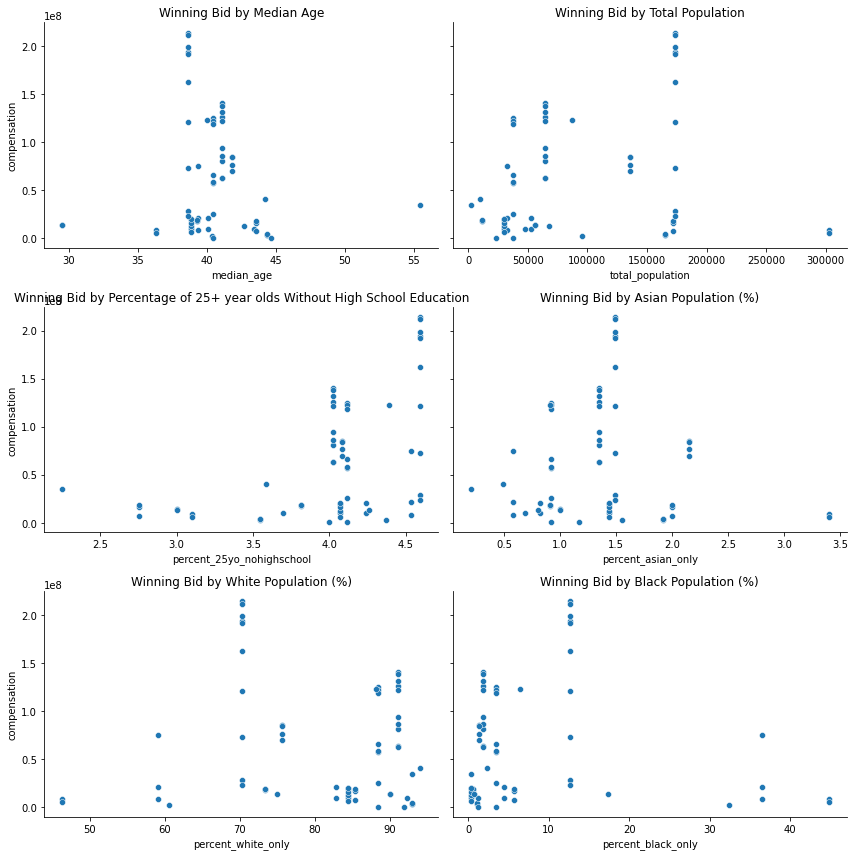

In [175]:
fig, axes = plt.subplots(3,2, figsize=(12,12), sharey=True)

# fig.suptitle("Winning Bid Scatterplots on Various Features")

color_pal = sns.color_palette(palette='pastel', n_colors=4)

for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

sns.scatterplot(ax = axes[0,0], data= full_by_facility, x = 'median_age', y='compensation', palette=color_pal)\
                .set(title = "Winning Bid by Median Age")

sns.scatterplot(ax = axes[0,1], data= full_by_facility, x = 'total_population', y='compensation', palette=color_pal)\
                .set(title ="Winning Bid by Total Population")

sns.scatterplot(ax = axes[1,0], data= full_by_facility, x ='percent_25yo_nohighschool', y= 'compensation', palette=color_pal)\
                .set(title = 'Winning Bid by Percentage of 25+ year olds Without High School Education')

sns.scatterplot(ax = axes[1,1], data= full_by_facility, x ='percent_asian_only', y= 'compensation', palette=color_pal)\
                .set(title = 'Winning Bid by Asian Population (%)')

sns.scatterplot(ax = axes[2,0], data= full_by_facility, x ='percent_white_only', y= 'compensation', palette=color_pal)\
                .set(title = 'Winning Bid by White Population (%)')

sns.scatterplot(ax = axes[2,1], data= full_by_facility, x ='percent_black_only', y= 'compensation', palette=color_pal)\
                .set(title = 'Winning Bid by Black Population (%)')



plt.tight_layout()

plt.show()

#px.scatter(data_frame=full_by_facility, x='percent_black_only', y='compensation')

#### Regression and Model Selection – `full_by_facility`

##### Split `full_by_facility` into training and testing sets

In [170]:
X = full_by_facility.iloc[:, full_by_facility.columns != 'compensation'].to_numpy()
y = full_by_facility['compensation'].to_numpy().reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state=123)

##### Fit Linear Regression Model + Initial Metrics

In [174]:
m1 = LinearRegression()

m1 = m1.fit(X_train, y_train)

prediction = m1.predict(X_test)

accuracy = m1.score(X_test, y_test)

MSE = mean_squared_error(y_test, prediction)

print("Accuracy score of model: ", accuracy)
print("Mean squared error of model: ", MSE)

Accuracy score of model:  -0.2006153130318058
Mean squared error of model:  2897306341176633.5
